# TCAV — Multimodal (CLIP)

This notebook runs TCAV variability on a multimodal model (**CLIP**) using the same caching and plotting framework.
We target gradients w.r.t. selected **vision** or **text** transformer layers and use a **similarity score** as the target logit.


In [ ]:
import os; os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [ ]:
# Local import shim
import sys, pathlib, os
os.environ.setdefault("TOKENIZERS_PARALLELISM", "false")
for p in (pathlib.Path.cwd().parent / "src", pathlib.Path.cwd().parents[1] / "src"):
    if (p / "tcavlab").exists():
        sys.path.insert(0, str(p))

import numpy as np, torch, pandas as pd
from PIL import Image

from tcavlab.plots import plot_variance_vs_n, plot_tcav_score_variance
from tcavlab.config import ExperimentConfig, DatasetConfig
from tcavlab.utils import set_all_seeds, device_auto, ensure_dir
from tcavlab.runners import precompute_cavs_for_layer
from tcavlab.analysis_utils import (
    load_cav_vector_variance_data_cached,
    load_sensitivity_score_variance_data_cached,
    calculate_tcav_score_variance_cached,
    precompute_gradients_for_class,
)
from tcavlab.models.multimodal import available_multimodal_models, choose_multimodal_model
from tcavlab.datasets.multimodal import load_images
from tcavlab.activations import get_mm_activations, get_mm_gradients

print("Available multimodal models:", available_multimodal_models())
import torch 
print(torch.__version__)


ImportError: cannot import name 'get_mm_activations' from 'tcavlab.activations' (/Users/juliawenkmann/Documents/CodingProjects/tcav_projects/tcav_variability/src/tcavlab/activations.py)

In [ ]:
# -----------------------------
# 1) Configuration
# -----------------------------
MODEL = "clip-vit-base-patch32"
MODEL_KEY = f"openai/{MODEL}"
METHOD = "dom"                # "dom" | "logistic" | "hinge"

# Choose a tower for analysis ("vision_hidden_k" or "text_hidden_k").
# We'll default to **vision** layers; edit this list as you like.
LAYER_NAMES = None  # if None we'll pick lower/mid/upper automatically

# Concept/image folders (image-only concepts for demonstration)
DATA_ROOT = "/Users/juliawenkmann/Documents/CodingProjects/tcav_projects/tcav_variability/src/tcavlab/datasets/TCAV_Images"
CONCEPTS = {
    "striped": os.path.join(DATA_ROOT, "concepts", "striped"),
    "zigzagged": os.path.join(DATA_ROOT, "concepts", "zigzagged"),
}
RANDOM_DIR = os.path.join(DATA_ROOT, "random")
TARGET_DIR = os.path.join(DATA_ROOT, "target", "zebra")   # images used to compute gradients

# Scoring configuration:
TARGET_TEXT = "a photo of a zebra"   # used for vision gradients (logits_per_image vs this text)
NEUTRAL_TEXT = "a photo."             # used when computing **activations** for vision layers

cfg = ExperimentConfig(
    dataset=DatasetConfig(
        name="multimodal_clip",
        concepts=list(CONCEPTS.keys()),
        target_class_name=TARGET_TEXT,
        target_class_index=0,   # not used; we define score via similarity instead
        data_paths={"concepts_root": os.path.join(DATA_ROOT, "concepts"),
                   "random_dir": RANDOM_DIR, "class_dir": TARGET_DIR},
    ),
    method=METHOD, 
    model_key=MODEL_KEY, 
    n_values=range(10,310,10),
    runs=5, 
    sets_per_run=5, 
    out_dir=f"artifacts/multimodal/{MODEL}/{METHOD}", 
    seed=42,
)
set_all_seeds(cfg.seed)
DEVICE = device_auto()
CACHE_DIR = os.path.join(cfg.out_dir, "cache")
os.makedirs(CACHE_DIR, exist_ok=True)
print("Device:", DEVICE)
LOAD_IF_EXISTS = False


Device: mps


In [ ]:
# -----------------------------
# 2) Model & layers
# -----------------------------
model, processor, DEVICE, info = choose_multimodal_model(cfg.model_key, device=DEVICE)
print("Vision layers (suggested):", info["vision_layers"])
print("Text layers (suggested):  ", info["text_layers"])
if LAYER_NAMES is None:
    LAYER_NAMES = info["vision_layers"]  # default to vision tower
print("Analyzing layers:", LAYER_NAMES)


/Users/juliawenkmann/miniconda3/envs/tcav_text/lib/python3.9/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/juliawenkmann/miniconda3/envs/tcav_text/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <FB2FD416-6C4D-3621-B677-61F07C02A3C5> /Users/juliawenkmann/miniconda3/envs/tcav_text/lib/python3.9/site-packages/torchvision/image.so
  Reason: tried: '/Users/juliawenkmann/miniconda3/envs/tcav_text/lib/python3.9/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/juliawenkmann/miniconda3/envs/tcav_text/lib/python3.9/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/juliawenkmann/miniconda3/envs/tcav_text/lib/python3.9/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/juliawenkmann/miniconda3/envs/tcav_text/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Vision layers (suggested): ['vision_hidden_4', 'vision_hidden_8', 'vision_hidden_12']
Text layers (suggested):   ['text_hidden_4', 'text_hidden_8', 'text_hidden_12']
Analyzing layers: ['vision_hidden_4', 'vision_hidden_8', 'vision_hidden_12']


In [ ]:
# -----------------------------
# 3) Load images
# -----------------------------
concept_images = {}
for cname, path in CONCEPTS.items():
    imgs = load_images(path)
    if not imgs: print(f"[WARN] No images in concept folder: {path}")
    concept_images[cname] = imgs
    print(cname, ":", len(imgs))

random_images = load_images(RANDOM_DIR)
target_images = load_images(TARGET_DIR)
print("Random:", len(random_images), " | Target:", len(target_images))
assert len(random_images) > 0, "Random folder is empty; please add images."
assert len(target_images) > 0, "Target folder is empty; please add images."


striped : 100
zigzagged : 100
Random: 913  | Target: 40


In [ ]:
# -----------------------------
# 4) Precompute CAVs for each layer & concept
# -----------------------------
for layer_name in LAYER_NAMES:
    print(f"=== Layer: {layer_name} ===")
    for concept in cfg.dataset.concepts:
        print(f"  Concept: {concept}")
        X_pos = get_mm_activations(model, processor, concept_images[concept], layer_name, DEVICE, neutral_text=NEUTRAL_TEXT, batch_size=16)
        X_neg = get_mm_activations(model, processor, random_images,           layer_name, DEVICE, neutral_text=NEUTRAL_TEXT, batch_size=16)
        base_dir = os.path.join(cfg.out_dir, layer_name, concept); ensure_dir(base_dir)
        precompute_cavs_for_layer(
            X_pos=X_pos, X_neg=X_neg, layer_name=layer_name, method=cfg.method,
            n_values=cfg.n_values, runs=cfg.runs, sets_per_run=cfg.sets_per_run,
            out_dir=base_dir, seed=cfg.seed,
        )
print("CAV precomputation done.")


=== Layer: vision_hidden_4 ===
  Concept: striped
CAV file already exists, skipping: artifacts/multimodal/clip-vit-base-patch32/dom/vision_hidden_4/striped/10/run_0.pkl
CAV file already exists, skipping: artifacts/multimodal/clip-vit-base-patch32/dom/vision_hidden_4/striped/10/run_1.pkl
CAV file already exists, skipping: artifacts/multimodal/clip-vit-base-patch32/dom/vision_hidden_4/striped/10/run_2.pkl
CAV file already exists, skipping: artifacts/multimodal/clip-vit-base-patch32/dom/vision_hidden_4/striped/10/run_3.pkl
CAV file already exists, skipping: artifacts/multimodal/clip-vit-base-patch32/dom/vision_hidden_4/striped/10/run_4.pkl
CAV file already exists, skipping: artifacts/multimodal/clip-vit-base-patch32/dom/vision_hidden_4/striped/20/run_0.pkl
CAV file already exists, skipping: artifacts/multimodal/clip-vit-base-patch32/dom/vision_hidden_4/striped/20/run_1.pkl
CAV file already exists, skipping: artifacts/multimodal/clip-vit-base-patch32/dom/vision_hidden_4/striped/20/run_2.pk

Plot saved to artifacts/multimodal/clip-vit-base-patch32/dom/plots/cav_vector_variance_clip-vit-base-patch32_vision_hidden_4_dom.pdf


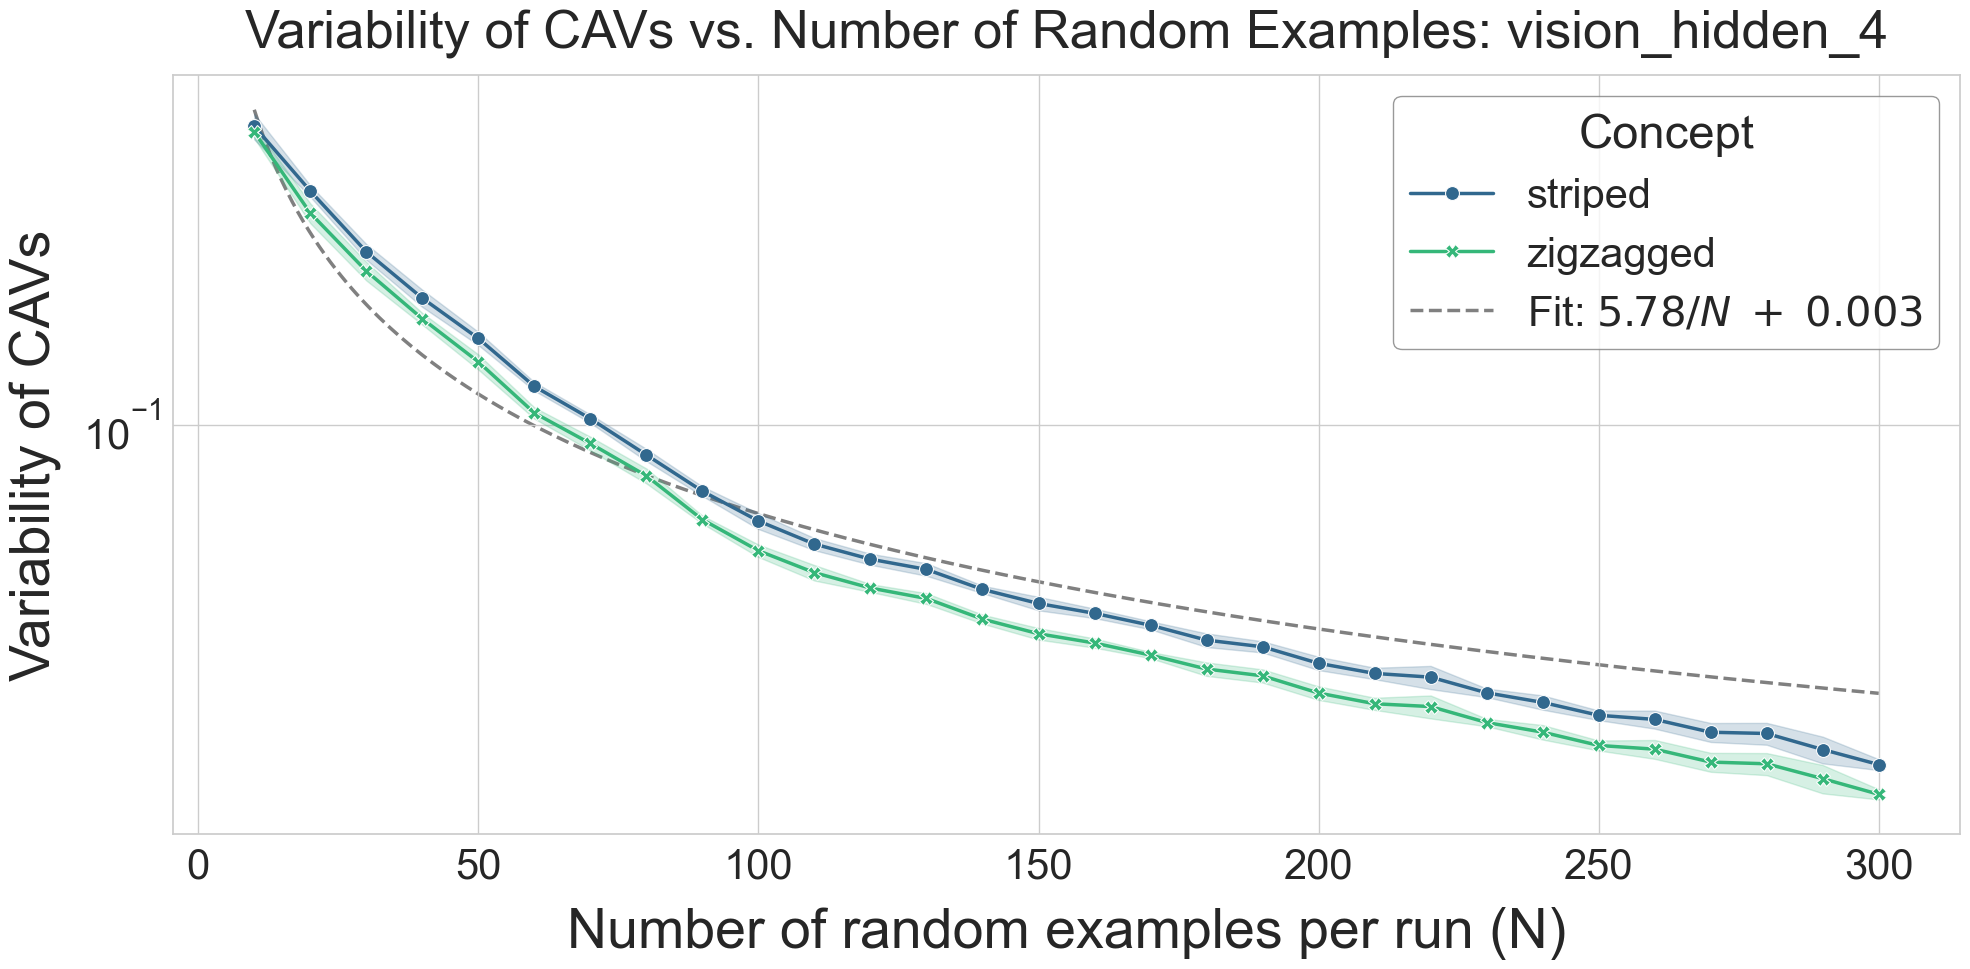

Plot saved to artifacts/multimodal/clip-vit-base-patch32/dom/plots/cav_vector_variance_clip-vit-base-patch32_vision_hidden_8_dom.pdf


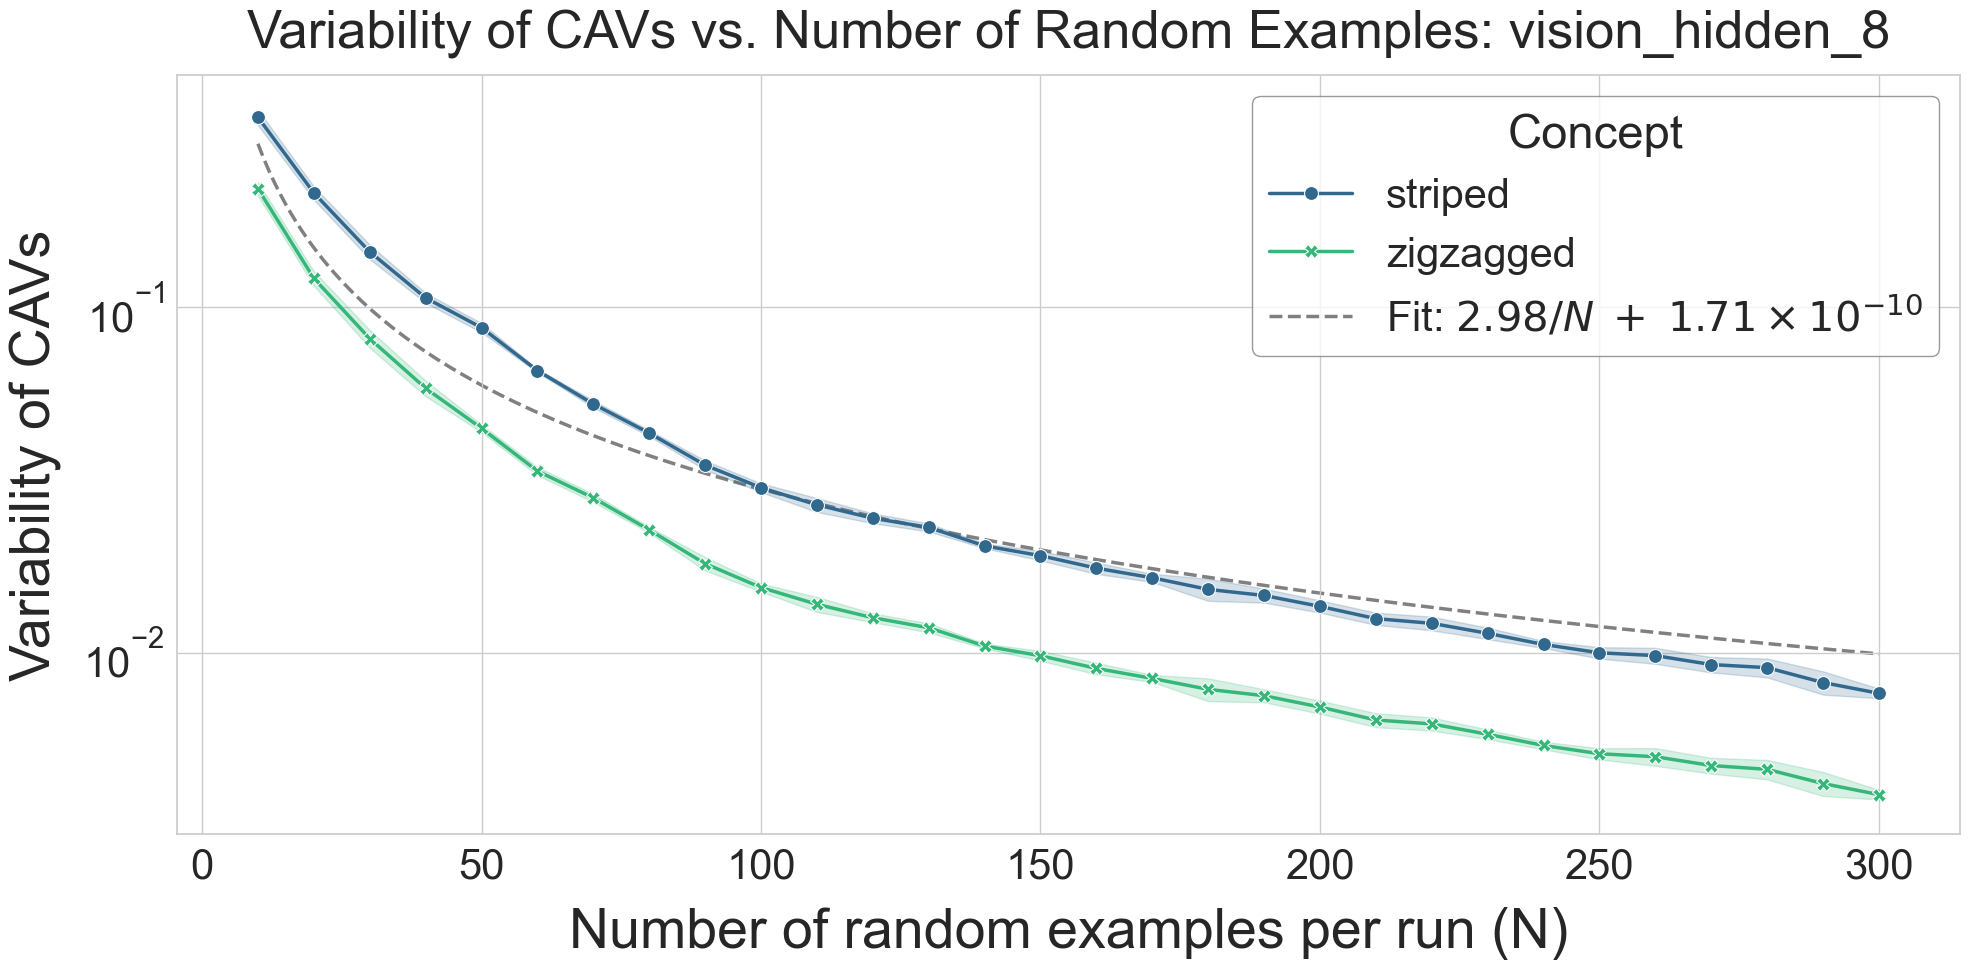

Plot saved to artifacts/multimodal/clip-vit-base-patch32/dom/plots/cav_vector_variance_clip-vit-base-patch32_vision_hidden_12_dom.pdf


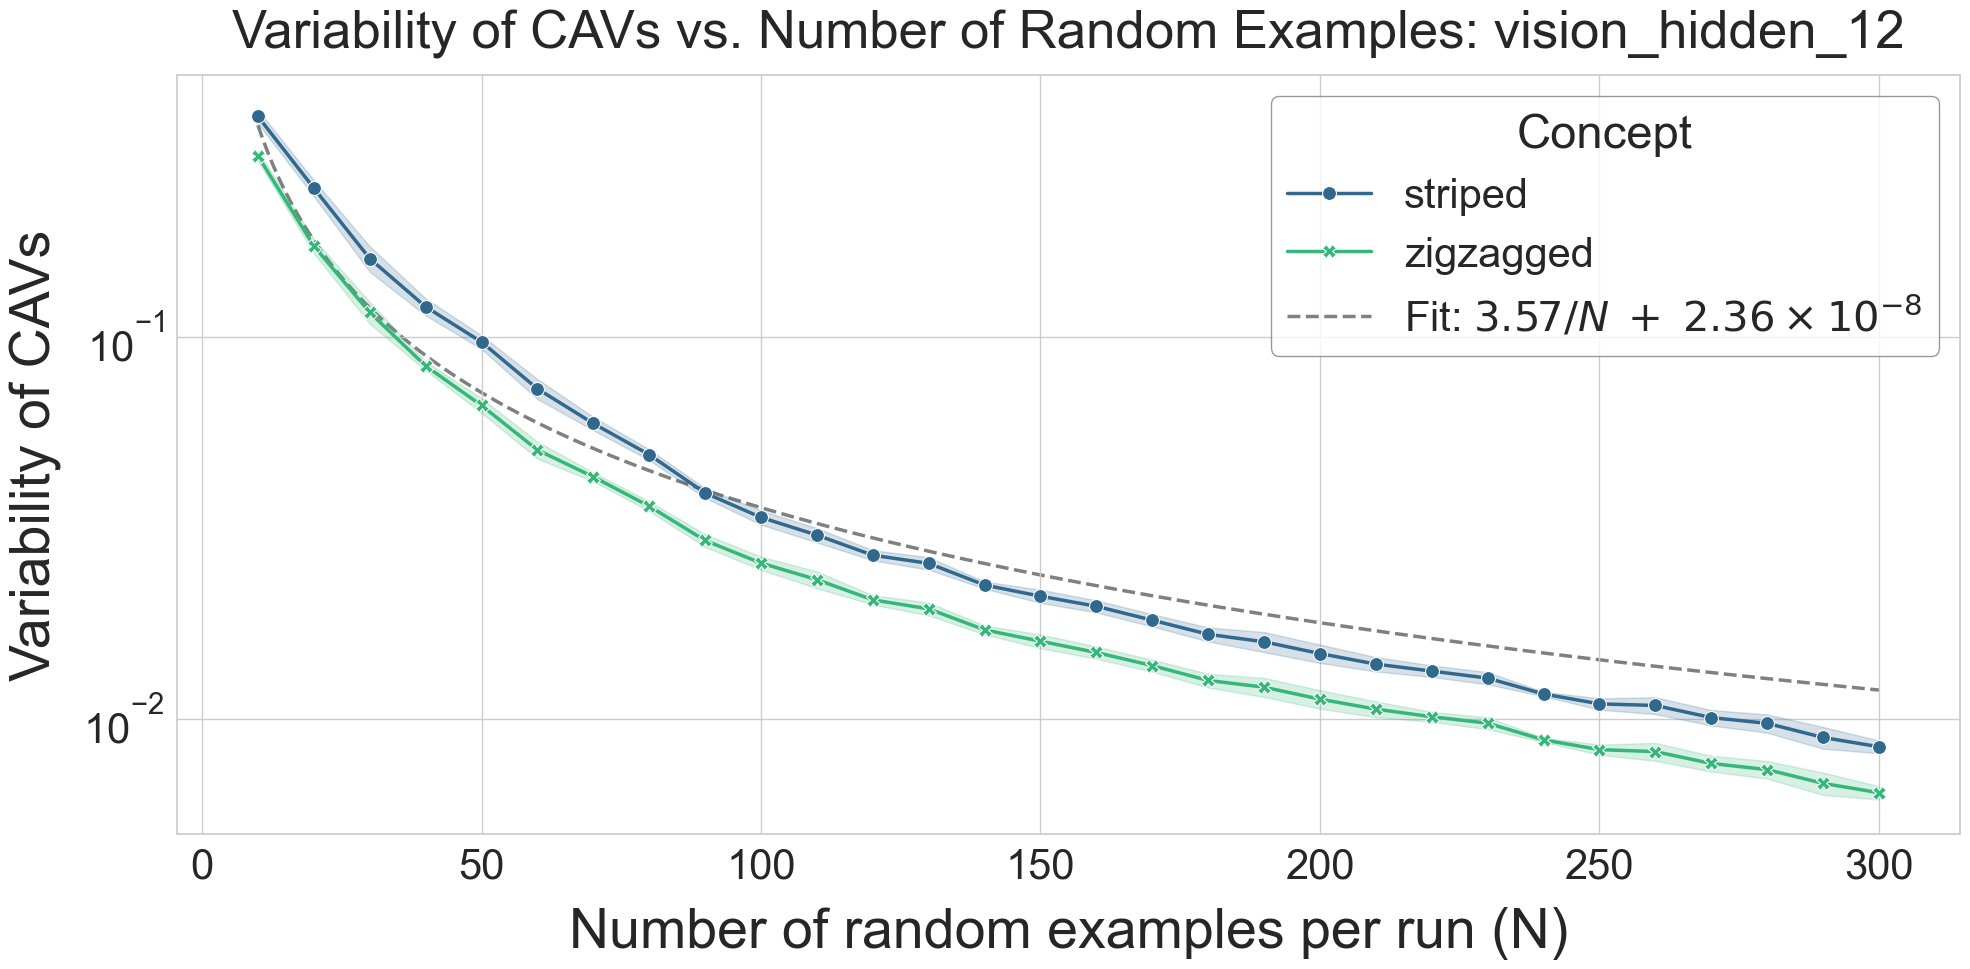

In [ ]:
# -----------------------------
# 5) Plot: CAV vector variability
# -----------------------------
for layer_name in LAYER_NAMES:
    df_var = load_cav_vector_variance_data_cached(
        layer=layer_name, cav_output_dir=cfg.out_dir,
        concepts_to_load=cfg.dataset.concepts, n_values=list(cfg.n_values),
        runs=int(cfg.runs), cache_dir=CACHE_DIR, cache_key=f"mm_trace_var__{layer_name}",
        load_if_exists=LOAD_IF_EXISTS, save=True,
    )
    plot_variance_vs_n(
        df=df_var, layer=layer_name,
        title=f"Variability of CAVs vs. Number of Random Examples: {layer_name}",
        ylabel="Variability of CAVs",
        save_path=os.path.join(cfg.out_dir, "plots", f"cav_vector_variance_{MODEL}_{layer_name}_{METHOD}.pdf"),
        fit_thresholds=[0], cache_dir=CACHE_DIR, cache_key=f"mm_trace_var_plot__{layer_name}",
        load_if_exists=LOAD_IF_EXISTS, save_bundle=True,
    )


Plot saved to artifacts/multimodal/clip-vit-base-patch32/dom/plots/sensitivity_variance_clip-vit-base-patch32_vision_hidden_4_dom.pdf


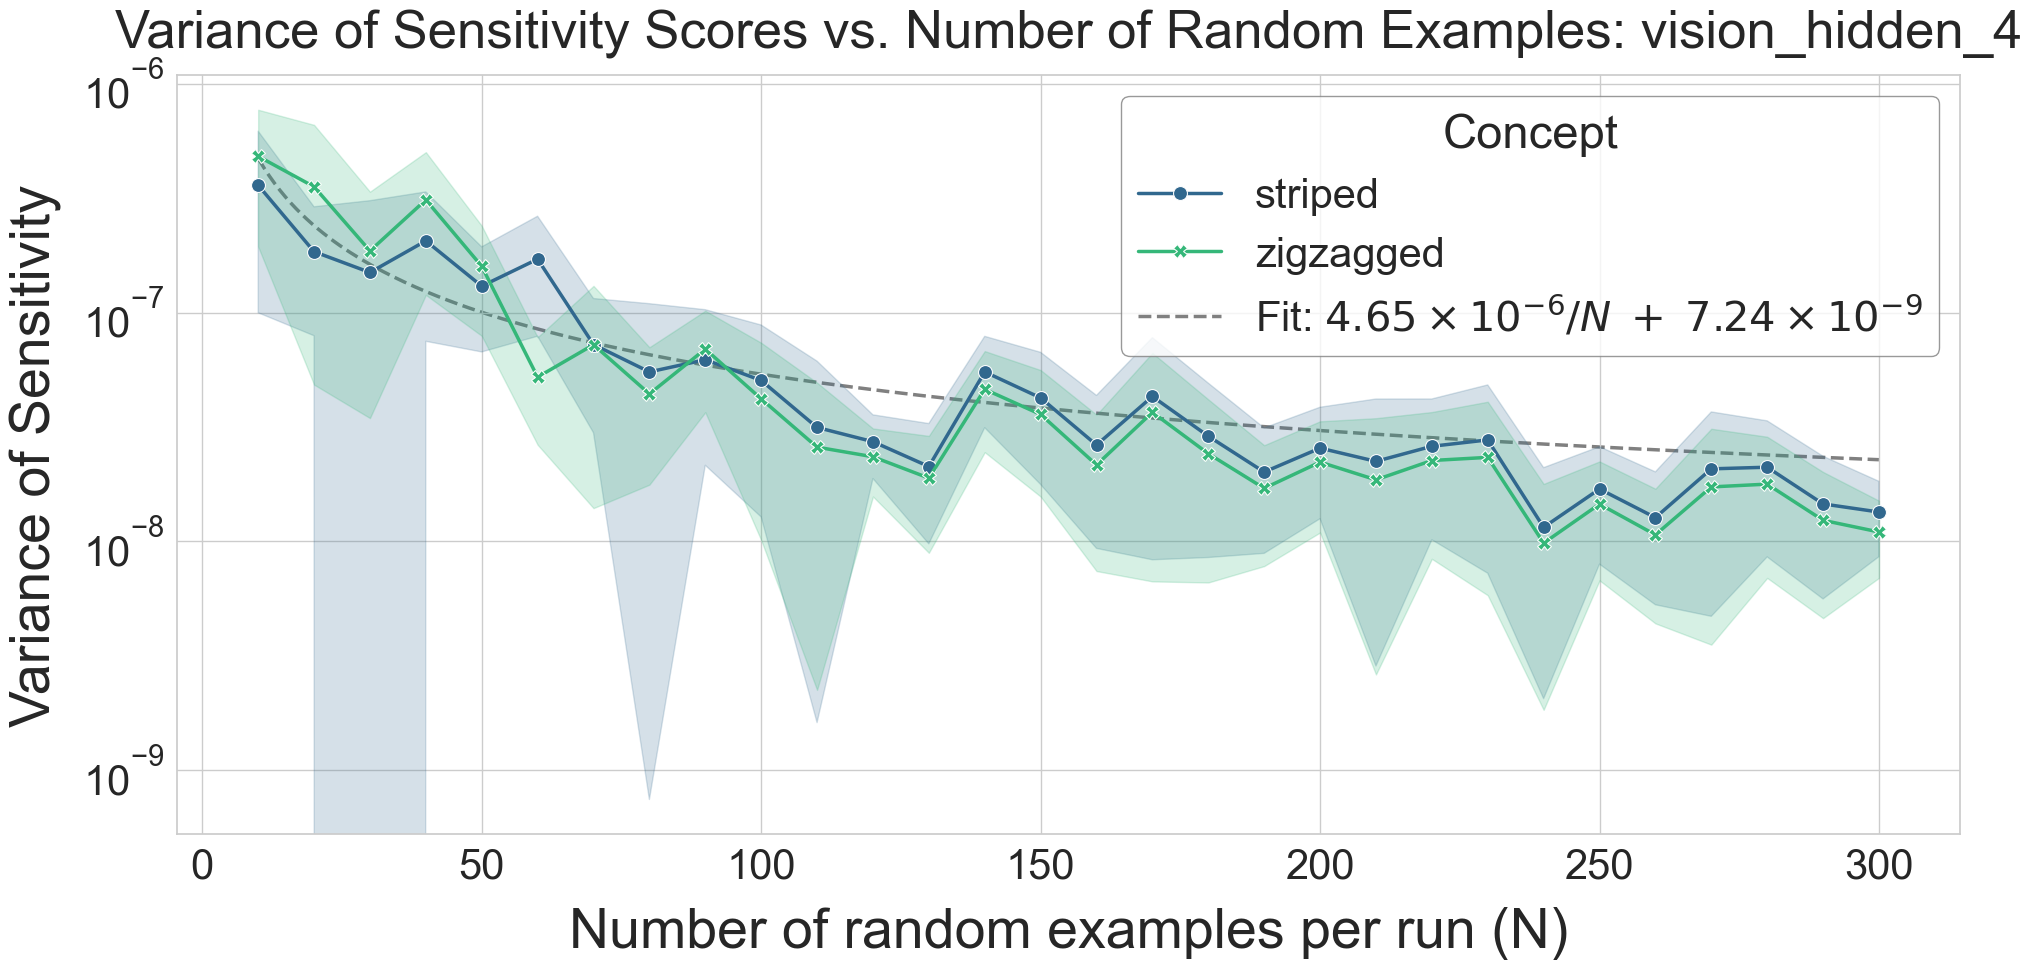

Plot saved to artifacts/multimodal/clip-vit-base-patch32/dom/plots/sensitivity_variance_clip-vit-base-patch32_vision_hidden_8_dom.pdf


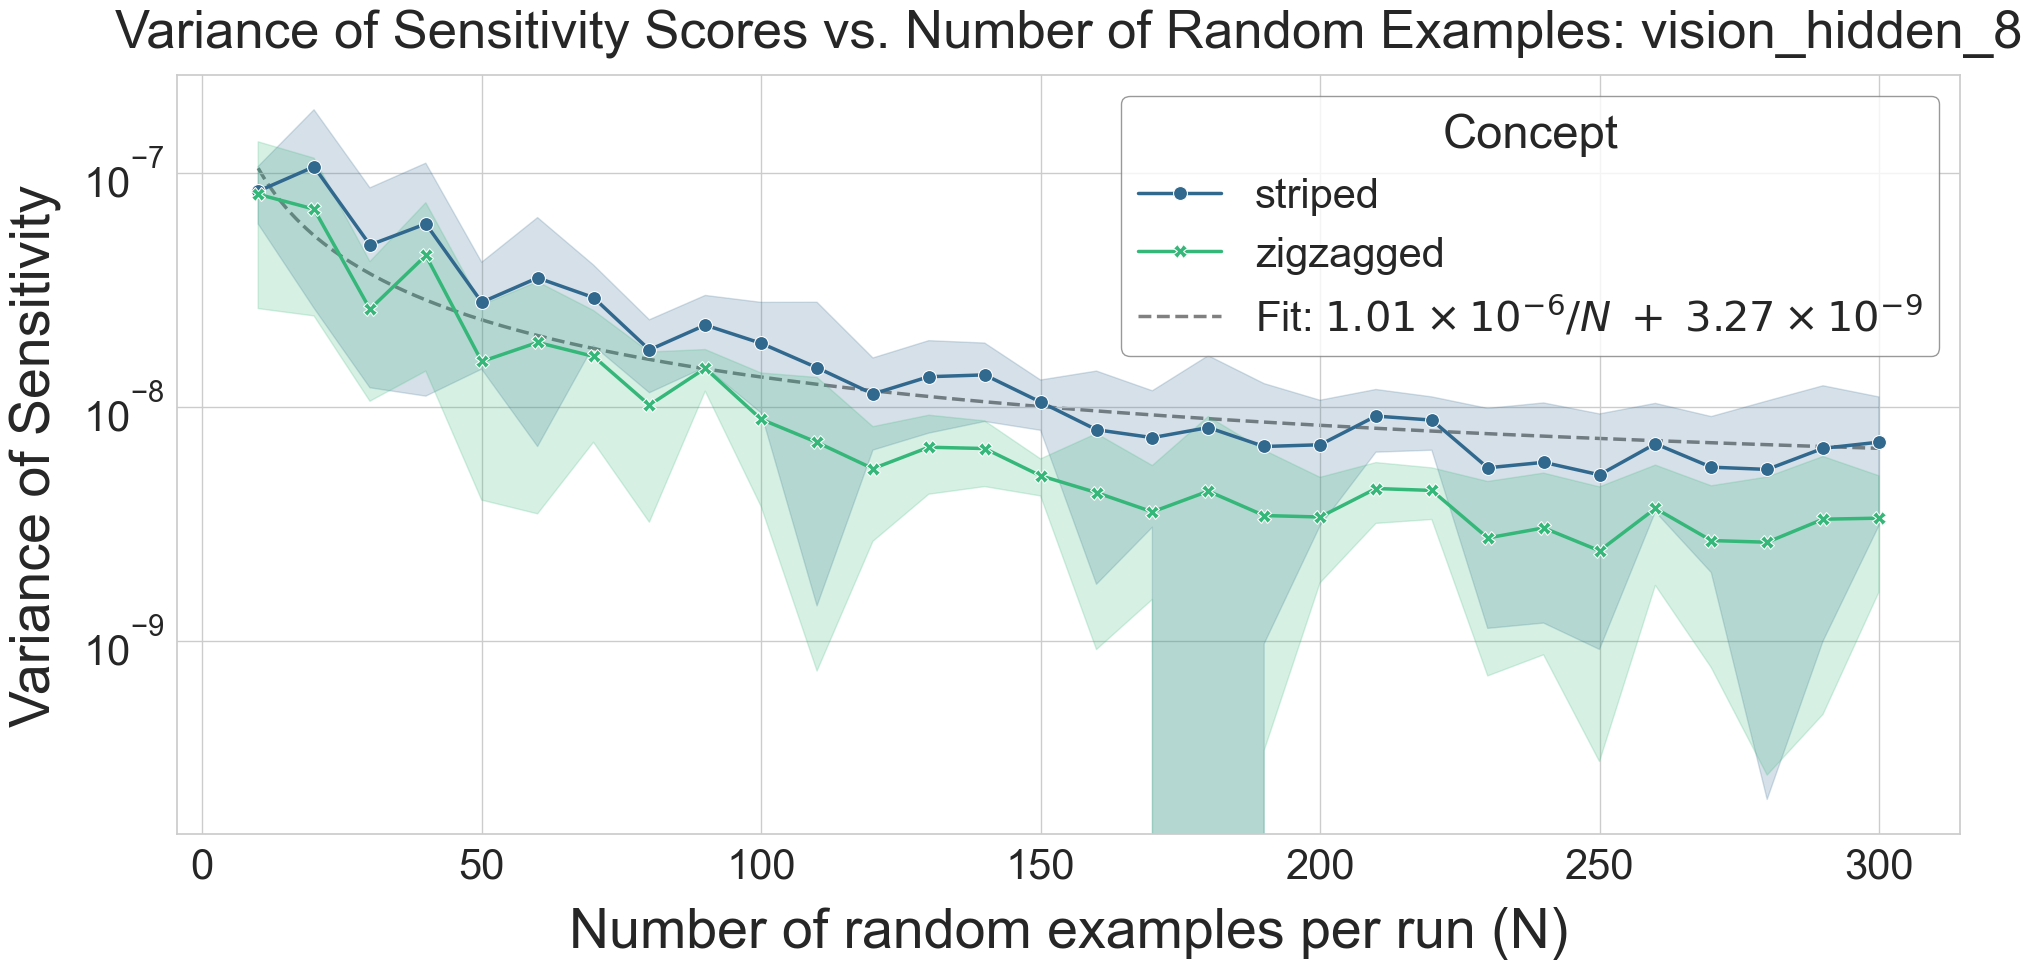

Plot saved to artifacts/multimodal/clip-vit-base-patch32/dom/plots/sensitivity_variance_clip-vit-base-patch32_vision_hidden_12_dom.pdf


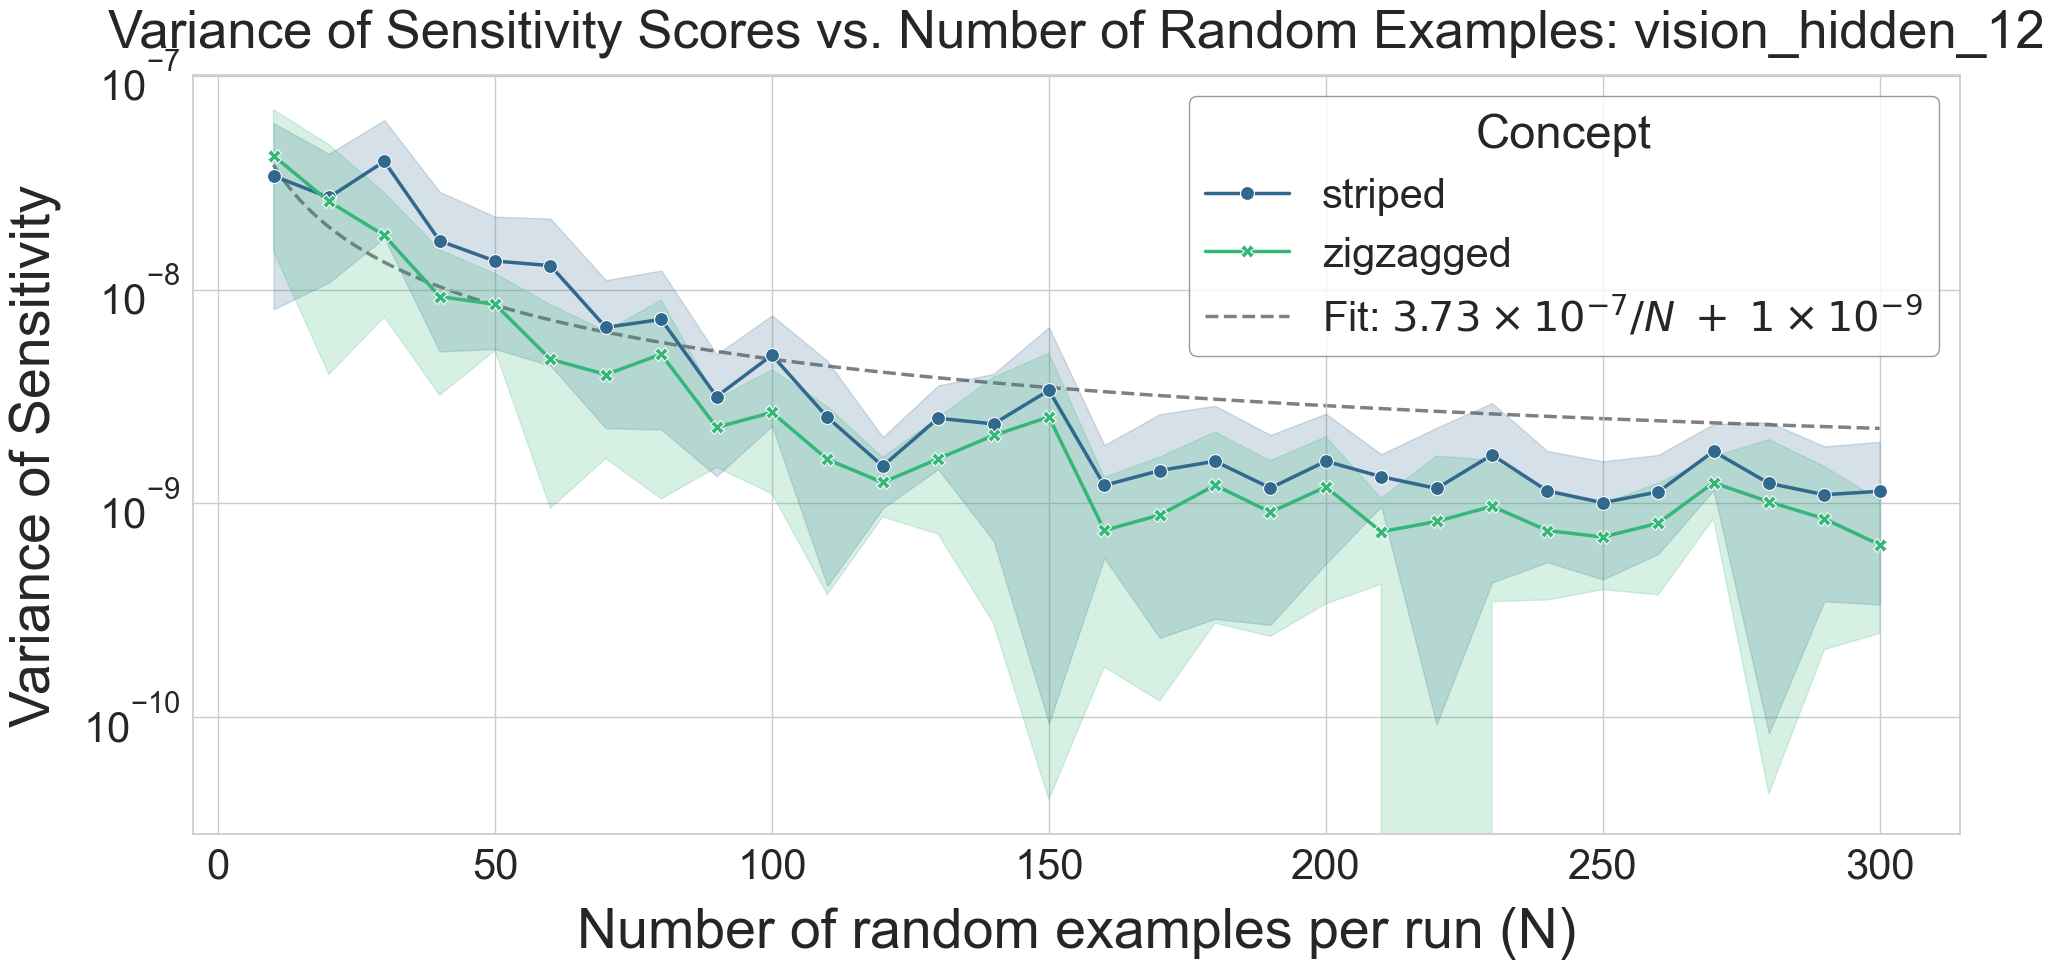

In [ ]:
# -----------------------------
# 6) Sensitivity score variance (single gradient vector)
# -----------------------------
for layer_name in LAYER_NAMES:
    # one target image -> gradient wrt selected layer to the TARGET_TEXT prompt similarity
    G_one = get_mm_gradients(model, processor, [target_images[0]], layer_name, DEVICE, target_text=TARGET_TEXT, batch_size=1)
    if G_one is None:
        print("No gradient for", layer_name); continue
    g_vec = G_one[0]  # [D]
    df_sens = load_sensitivity_score_variance_data_cached(
        layer=layer_name, gradient_vector=g_vec, cav_output_dir=cfg.out_dir,
        concepts_to_load=cfg.dataset.concepts, n_values=list(cfg.n_values), runs=int(cfg.runs),
        cache_dir=CACHE_DIR, cache_key=f"mm_sens_var__{layer_name}", load_if_exists=LOAD_IF_EXISTS, save=True,
    )
    plot_variance_vs_n(
        df=df_sens, layer=layer_name,
        title=f"Variance of Sensitivity Scores vs. Number of Random Examples: {layer_name}",
        ylabel="Variance of Sensitivity",
        save_path=os.path.join(cfg.out_dir, "plots", f"sensitivity_variance_{MODEL}_{layer_name}_{METHOD}.pdf"),
        fit_thresholds=[0], cache_dir=CACHE_DIR, cache_key=f"mm_sens_var_plot__{layer_name}",
        load_if_exists=LOAD_IF_EXISTS, save_bundle=True,
    )


In [ ]:
# one batch through the vision tower
test = target_images[:4]
G = get_mm_gradients(model, processor, test, LAYER_NAMES[0], DEVICE, target_text=TARGET_TEXT, batch_size=4)
print("Grad shape:", None if G is None else G.shape)  # (4, S*D) expected

RuntimeError: view size is not compatible with input tensor's size and stride (at least one dimension spans across two contiguous subspaces). Use .reshape(...) instead.

In [ ]:
# -----------------------------
# 7) TCAV score variance (grads over many target images)
# -----------------------------
# Precompute grads for a batch of target images wrt the TARGET_TEXT prompt
grads_by_layer = {}
BATCH = 8
for layer_name in LAYER_NAMES:
    allg = []
    for i in range(0, len(target_images), BATCH):
        G = get_mm_gradients(model, processor, target_images[i:i+BATCH], layer_name, DEVICE, target_text=TARGET_TEXT, batch_size=BATCH)
        if G is not None:
            allg.append(G)
    if allg:
        import numpy as np
        grads_by_layer[layer_name] = np.vstack(allg)
        print("Gradients for", layer_name, grads_by_layer[layer_name].shape)

for layer_name in LAYER_NAMES:
    if layer_name not in grads_by_layer:
        print("Skip TCAV score variance for", layer_name); continue
    df_tcav = calculate_tcav_score_variance_cached(
        layers=[layer_name], concepts_to_load=cfg.dataset.concepts, n_values=list(cfg.n_values), runs=int(cfg.runs),
        gradients_per_layer=grads_by_layer, cav_output_dir=cfg.out_dir,
        cache_dir=CACHE_DIR, cache_key=f"mm_tcav_score_var__{layer_name}", load_if_exists=True, save=True,
    )
    df_layer = df_tcav[df_tcav["layer"] == layer_name].copy()
    plot_tcav_score_variance(
        df=df_layer, layer_name=layer_name, palette="plasma",
        save_path=os.path.join(cfg.out_dir, "plots", f"tcav_score_variance_{MODEL}_{layer_name}_{METHOD}.pdf"),
        cache_dir=CACHE_DIR, cache_key=f"mm_tcav_score_var_plot__{layer_name}", load_if_exists=True, save_bundle=True,
    )
print("All multimodal analyses complete.")


RuntimeError: view size is not compatible with input tensor's size and stride (at least one dimension spans across two contiguous subspaces). Use .reshape(...) instead.